# **Chest X-Ray Images (Pneumonia) Dataset**

> [**Kaggle Dataset**](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?datasetId=17810&sortBy=voteCount)

In [ ]:
# Install Kaggle.
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# Files Upload.
from google.colab import files

files.upload()

In [ ]:
# Create a Kaggle Folder.
!mkdir ~/.kaggle

# Copy the kaggle.json to the folder created.
!cp kaggle.json ~/.kaggle/

# Permission for the json file to act.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dataset Download.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
# Unzip Dataset.
!unzip chest-xray-pneumonia.zip

# **Pneumonia Classification Task**

In [ ]:
# Import Library.
import os, cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings

warnings.filterwarnings("ignore")

labels = ["PNEUMONIA", "NORMAL"]
img_size = 150


def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size.
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


# Load Dataset.
train = get_training_data("/content/chest_xray/chest_xray/train")
test = get_training_data("/content/chest_xray/chest_xray/test")
val = get_training_data("/content/chest_xray/chest_xray/val")

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



## **Data Visualization & Preprocessing.**

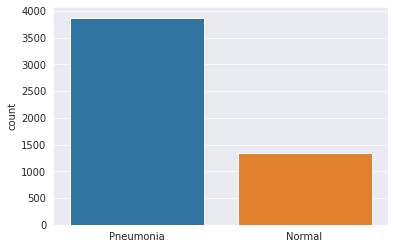

In [ ]:
l = []
for i in train:
    if i[1] == 0:
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style("darkgrid")
sns.countplot(l)

**The dataset is imbalanced. To increase the number of training examples, we will use the data augmentation technique.**

Text(0.5, 1.0, 'NORMAL')

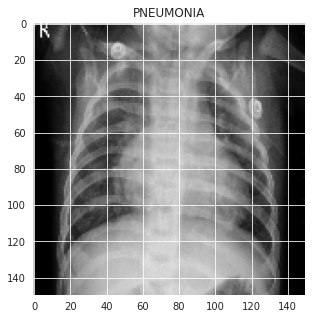

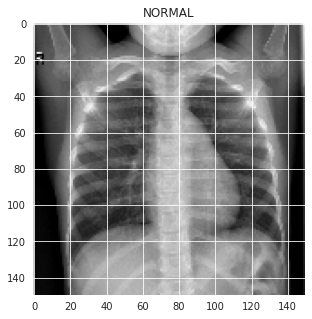

In [ ]:
# Preview the images of both the classes.
plt.figure(figsize=(5, 5))
plt.imshow(train[0][0], cmap="gray")
plt.title(labels[train[0][1]])

plt.figure(figsize=(5, 5))
plt.imshow(train[-1][0], cmap="gray")
plt.title(labels[train[-1][1]])

In [ ]:
# Split Dataset into Training, Testing, and Validation Set.
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences. Moreover, the CNN converges faster on $[0 ... 1]$ data rather than on $[0 .... 255]$.**

In [ ]:
# Normalize the Dataset.
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

# Reshape Dataset.
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## **Data Augmentation.**

To avoid the overfitting problem, we need to expand our dataset artificially. We can make our existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Popular augmentations techniques are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, etc. Applying some of these transformations to our training dataset can increase the number of training examples and helps create a robust model.


For the data augmentation, we chose to:

*   Randomly rotate some training images by 30 degrees.
*   Randomly Zoom some training images by 20%.
*   Randomly shift the training images horizontally by 10% of the width.
*   Randomly shift the training images vertically by 10% of the height.
*   Randomly flip the training images horizontally. Once the model is ready, we fit the training dataset.

In [ ]:
# Data Augmentation prevents overfitting and handles the imbalance in the dataset.

datagen = ImageDataGenerator(
    featurewise_center=False,  # Set input mean to 0 over the dataset.
    samplewise_center=False,  # Set each sample mean to 0.
    featurewise_std_normalization=False,  # Divide inputs by std of the dataset.
    samplewise_std_normalization=False,  # Divide each input by its std.
    zca_whitening=False,  # Apply ZCA whitening.
    rotation_range=30,  # Randomly rotate images in the range (degrees, 0 to 180).
    zoom_range=0.2,  # Randomly Zoom image.
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width).
    height_shift_range=0.1,  # Randomly shift images vertically (fraction of total height).
    horizontal_flip=True,  # Randomly flip images.
    vertical_flip=False,  # Randomly flip images.
)

datagen.fit(X_train)

## **Training the Pneumonia Classification Model.**

In [ ]:
# Build Model Pipeline.
def build_model():
    model = Sequential()
    model.add(
        Conv2D(
            32,
            (3, 3),
            strides=1,
            padding="same",
            activation="relu",
            input_shape=(150, 150, 1),
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=128, activation="relu"))
    model.add(Dropout(0.4))
    model.add(Dense(units=64, activation="relu"))
    model.add(Dense(units=1, activation="sigmoid"))
    # Compile the Model.
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Call Model Architecture.
pneumonia_detector = build_model()
pneumonia_detector.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                        

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=2, verbose=1, factor=0.3, min_lr=0.000001
)

# Fit the Model.
history = pneumonia_detector.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=15,
    validation_data=datagen.flow(X_val, y_val),
    callbacks=[learning_rate_reduction],
)

Epoch 1/15
163/163 [==============================] - 24s 67ms/step - loss: 0.4434 - accuracy: 0.8298 - val_loss: 13.0777 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 11s 64ms/step - loss: 0.2690 - accuracy: 0.8884 - val_loss: 16.0787 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.8938
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 11s 70ms/step - loss: 0.2581 - accuracy: 0.8938 - val_loss: 4.9632 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - 10s 64ms/step - loss: 0.1981 - accuracy: 0.9225 - val_loss: 0.4612 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 5/15
163/163 [==============================] - 10s 64ms/step - loss: 0.1745 - accuracy: 0.9308 - val_loss: 6.7612 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/15
163/163 [========================

In [ ]:
print("Loss of the Model is", pneumonia_detector.evaluate(X_test, y_test)[0])
print("Accuracy of the Model is", pneumonia_detector.evaluate(X_test, y_test)[1] * 100, "%")

20/20 [==============================] - 1s 12ms/step - loss: 0.2913 - accuracy: 0.9022
Loss of the Model is 0.2913004457950592
20/20 [==============================] - 0s 12ms/step - loss: 0.2913 - accuracy: 0.9022
Accuracy of the Model is 90.22436141967773 %


## **Analysis after Model Training.**

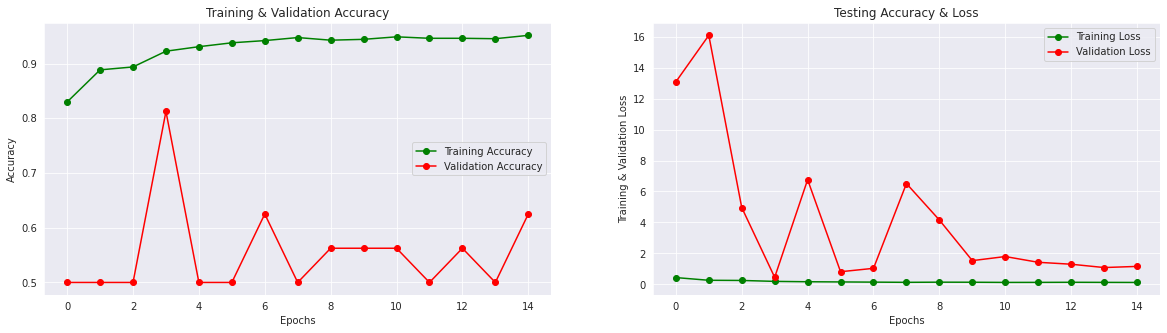

In [ ]:
epochs = [i for i in range(15)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 5)

ax[0].plot(epochs, train_acc, "go-", label="Training Accuracy")
ax[0].plot(epochs, val_acc, "ro-", label="Validation Accuracy")
ax[0].set_title("Training & Validation Accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "g-o", label="Training Loss")
ax[1].plot(epochs, val_loss, "r-o", label="Validation Loss")
ax[1].set_title("Testing Accuracy & Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (pneumonia_detector.predict(X_test) > 0.5) * 1
predictions = predictions.reshape(1, -1)[0]
predictions[:15]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(classification_report(y_test, predictions, target_names=["Pneumonia (Class 0)", "Normal (Class 1)"]))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.95      0.92       390
   Normal (Class 1)       0.90      0.83      0.86       234

           accuracy                           0.90       624
          macro avg       0.90      0.89      0.89       624
       weighted avg       0.90      0.90      0.90       624



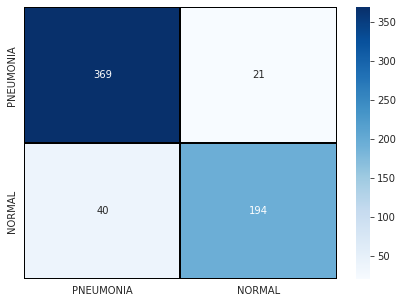

In [ ]:
# Confusion Matrix.
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index=["0", "1"], columns=["0", "1"])

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm,
    cmap="Blues",
    linecolor="black",
    linewidth=1,
    annot=True,
    fmt="",
    xticklabels=labels,
    yticklabels=labels,
)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes.**

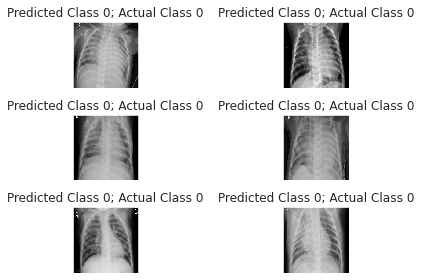

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150, 150), cmap="gray", interpolation="None")
    plt.title("Predicted Class {}; Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes.**

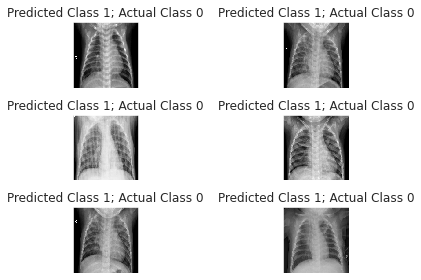

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150, 150), cmap="gray", interpolation="None")
    plt.title("Predicted Class {}; Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1